In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
import altair as alt
from altair import datum
from tqdm.auto import tqdm, trange

from src.model import tscv

%run constants.py

%matplotlib inline
print("Versions:")
print("  Python: %s" % sys.version)
for module in [pd, np, sns, sklearn, alt]:
    print("  %s: %s" %(module.__name__, module.__version__))

Versions:
  Python: 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
  pandas: 1.1.0
  numpy: 1.19.1
  seaborn: 0.10.1
  sklearn: 0.23.2
  altair: 4.1.0


# Feature Engineering

I think we have enough information to start with feature engineering now.

The first step in my opinion is to define a validation pipeline, which is described in the next session.

## Validation pipeline

First of all, we need our metric, which sould be `sklearn.metrics.mean_squared_error(squared=False)`.

Now, we need to decide how our training set should be split to validate a model. Since the problem is about forecasting, I chose to do a time-series split for this. This means I'll train on the dataset where `date_block_num < k` and predict for dataset where `date_block_num = k`, for `k in [31, 32, 33]`.

In [2]:
train_set = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'train-set-base.parquet'))
train_set.head()

,date_block_num,item_id,shop_id,item_cnt
0,0,33,2,1.0
1,0,317,2,1.0
2,0,438,2,1.0
3,0,471,2,2.0
4,0,481,2,1.0


In order to use more of the dataset I'll use everything for CV and use the public LB score as the generalization score.

In [3]:
tscv.split(train_set['date_block_num'].values)

[(array([      0,       1,       2, ..., 1506157, 1506158, 1506159]),
  array([1506160, 1506161, 1506162, ..., 1539643, 1539644, 1539645])),
 (array([      0,       1,       2, ..., 1539643, 1539644, 1539645]),
  array([1539646, 1539647, 1539648, ..., 1569321, 1569322, 1569323])),
 (array([      0,       1,       2, ..., 1569321, 1569322, 1569323]),
  array([1569324, 1569325, 1569326, ..., 1600852, 1600853, 1600854]))]

With that we can use scikit learn to evaluate a regressor. Let's prepare our matrices and try a random forest just as an exercise.

In [4]:
cv_splits = tscv.split(train_set['date_block_num'].values)
X_train, y_train = train_set.drop(columns='item_cnt').values, train_set['item_cnt'].values

We also need to remember to trim the outputs. For that I'll use a wrapper I wrote. Every estimator should be wrapped with it to have the output automatically clipped.

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from src.model import ClippedOutputRegressor

reg = ClippedOutputRegressor(RandomForestRegressor(n_estimators=30, n_jobs=-1, verbose=1))
scores = cross_validate(reg, X=X_train, y=y_train,
                        scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1, 
                        cv=cv_splits, return_train_score=True)
scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   47.8s finished


{'fit_time': array([42.19428134, 42.98557067, 43.57930064]),
 'score_time': array([0.08686161, 0.28909612, 0.42412257]),
 'test_score': array([-1.74787287, -2.23176135, -2.35461043]),
 'train_score': array([-0.6457319 , -0.64383231, -0.64148027])}

In [7]:
scores['test_score'].mean()

-2.111414882776397

We can verify if our validation split is good by comparing with our generalization score. Since we're using the public LB, let's fit the model to the whole train set, create a submission and send it.

In [8]:
test_set = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'test-set-base.parquet'))
reg.fit(X_train, y_train)
y_pred = reg.predict(test_set.drop(columns='ID').values)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  30 out of  30 | elapsed:    0.2s finished


In [9]:
submission = pd.DataFrame({'ID': test_set['ID'], 'item_cnt_month': y_pred})
submission.to_csv(os.path.join(TMP_DIR, 'rf-exercise-submission.csv'), index=False)

In [10]:
%%bash
kaggle c submit -f ${TMP_DIR}/rf-exercise-submission.csv -m 'testing CV score using a RF' competitive-data-science-predict-future-sales

Successfully submitted to Predict Future Sales

100%|██████████| 3.93M/3.93M [00:12<00:00, 335kB/s] 


In [11]:
submission.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,1.424671
std,61834.358168,1.199721
min,0.000000,0.300000
25%,53549.750000,1.033333
50%,107099.500000,1.166667
75%,160649.250000,1.400000
max,214199.000000,20.000000


The score on the public LB is 1.88491, which is not close enough to our mean test score for me.

Upon closer inspection, we can see the model actually overfitting because of the amount of data: the test score is getting worse while the train score is getting better. It's too early to act on that, but `tscv.split` has a `window` paramater that we can tweak.

But maybe this is because of the chosen months. To visualize this, let's fix the month and vary only the window length.

In [12]:
dates = train_set['date_block_num'].values
windows_splits = [(np.where(dates >= 33 - w)[0], np.where(dates == 33)[0])
                  for w in range(1, 34)]
windows_splits[:10]

[(array([1539646, 1539647, 1539648, ..., 1600852, 1600853, 1600854]),
  array([1569324, 1569325, 1569326, ..., 1600852, 1600853, 1600854])),
 (array([1506160, 1506161, 1506162, ..., 1600852, 1600853, 1600854]),
  array([1569324, 1569325, 1569326, ..., 1600852, 1600853, 1600854])),
 (array([1472633, 1472634, 1472635, ..., 1600852, 1600853, 1600854]),
  array([1569324, 1569325, 1569326, ..., 1600852, 1600853, 1600854])),
 (array([1440724, 1440725, 1440726, ..., 1600852, 1600853, 1600854]),
  array([1569324, 1569325, 1569326, ..., 1600852, 1600853, 1600854])),
 (array([1408504, 1408505, 1408506, ..., 1600852, 1600853, 1600854]),
  array([1569324, 1569325, 1569326, ..., 1600852, 1600853, 1600854])),
 (array([1375631, 1375632, 1375633, ..., 1600852, 1600853, 1600854]),
  array([1569324, 1569325, 1569326, ..., 1600852, 1600853, 1600854])),
 (array([1335167, 1335168, 1335169, ..., 1600852, 1600853, 1600854]),
  array([1569324, 1569325, 1569326, ..., 1600852, 1600853, 1600854])),
 (array([1293

In [13]:
scores = cross_validate(reg, X=X_train, y=y_train,
                        scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1, 
                        cv=windows_splits, return_train_score=True)
scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  33 | elapsed:  4.0min remaining:   52.9s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:  4.4min finished


{'fit_time': array([  4.52534199,   7.88994384,  10.4708035 ,  13.45021272,
         17.23910999,  20.37744761,  25.34409404,  28.90832758,
         34.37848234,  37.37173653,  43.34159684,  48.28351712,
         57.20768523,  62.88230276,  67.27182889,  74.54134178,
         79.78189969,  87.48417807,  94.65934944, 100.82706451,
        110.36343336, 121.77316236, 126.63337922, 134.19145536,
        138.8156631 , 139.6626668 , 142.68819332, 141.46605611,
        138.83562326, 132.7873497 , 124.52139473, 116.87628388,
        102.76078439]),
 'score_time': array([0.63493252, 0.52236533, 0.59264088, 0.69544005, 0.5704596 ,
        0.52924752, 0.55239987, 0.5612545 , 0.6579144 , 0.60722208,
        0.69230747, 0.65601659, 0.68808293, 0.65025377, 0.60070109,
        0.5881505 , 0.64805174, 0.6864686 , 0.68516827, 0.63303447,
        0.58063364, 0.70729089, 0.67419672, 0.52665281, 0.43456984,
        0.56268191, 0.4857409 , 0.3887589 , 0.39943218, 0.3215251 ,
        0.31105661, 0.31004786

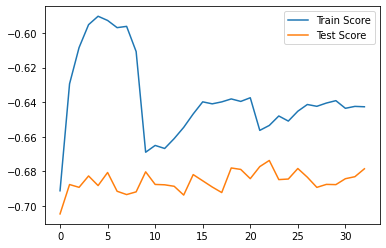

In [14]:
plt.plot(scores['train_score'], label='Train Score')
plt.plot(scores['test_score'], label='Test Score')
plt.legend()

It doesn't seem to be the case. We can test it again later when we have actual features.